# Определение стоимости автомобилей

**Описание задачи**  
Сервис по продаже автомобилей с пробегом разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Необходимо создать модель, которая умеет её определять. В распоряжении имеются данные о технических характеристиках, комплектации и ценах других автомобилей.
  
Критерии, которые важны заказчику:  
качество предсказания;  
время обучения модели;  
время предсказания модели.  
  
**Признаки**
  
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
Repaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
  
**Целевой признак**  
  
Price — цена (евро)
  
**Принятые допущения**  
Год регистрации автомобиля (столбец RegistrationYear) является годом выпуска конкретного автомобиля  
Оценивать рыночную стоимость предполагается для автомобилей массового сегмента

## Подготовка данных

### Ознакомление с данными

In [1]:
#подключение необходходимых для работы библиотек, модулей, метрик
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)

In [3]:
#загрузка данных
data = pd.read_csv('/datasets/autos.csv')

In [4]:
#общие сведения о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
#вывод первых 5 строк data
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Построим гистограммы для выявления аномалий

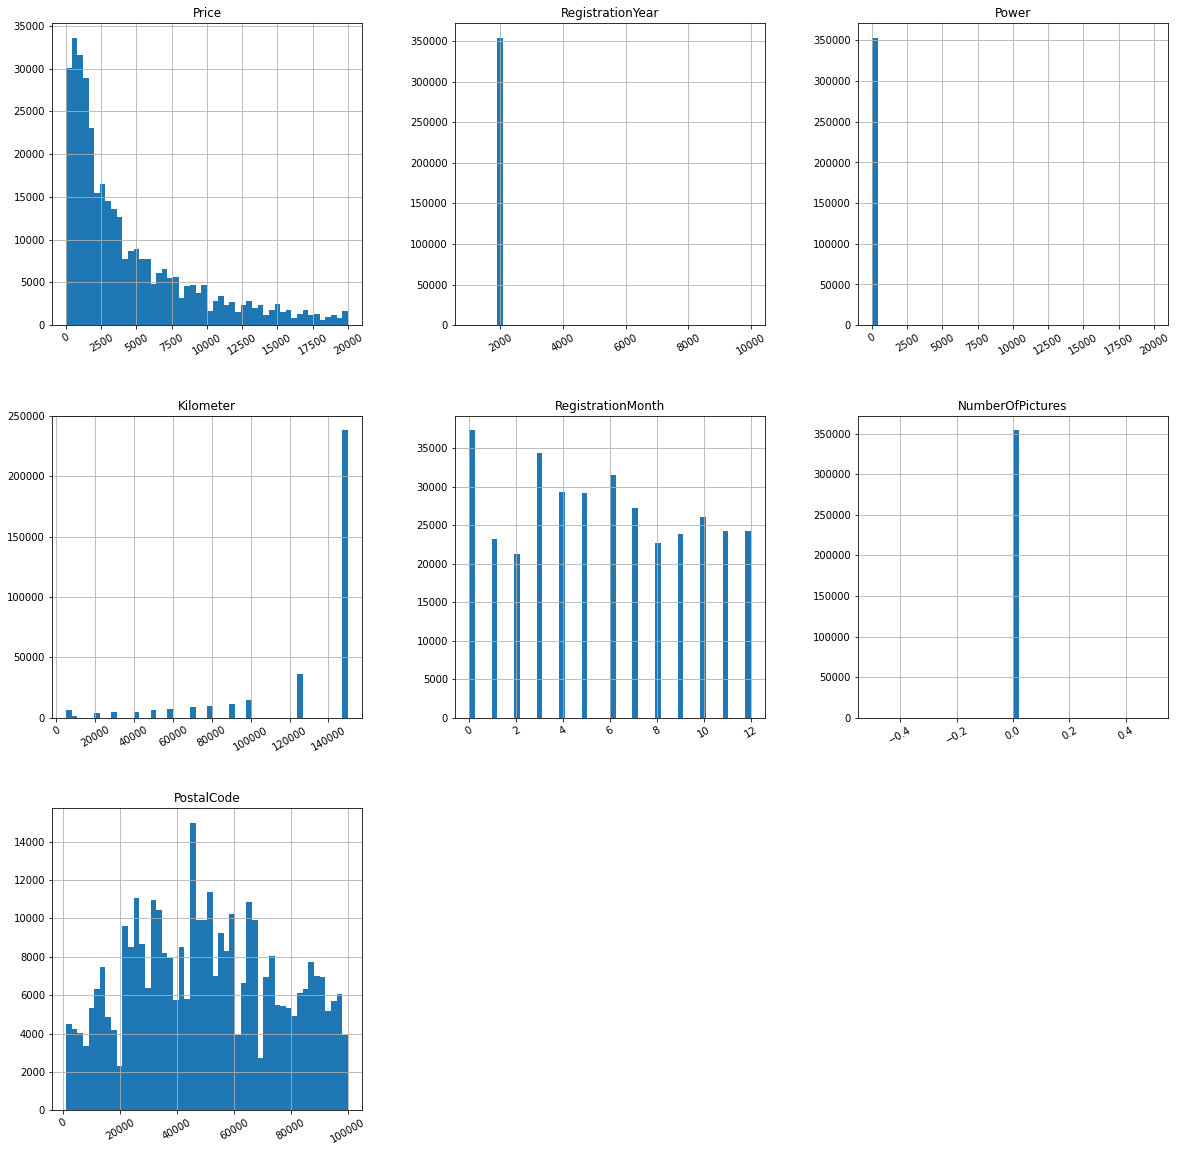

In [6]:
data.hist(figsize=(20,20), bins=50, xrot=30)

plt.show()

Построим диаграммы размаха для столбцов 'RegistrationYear', 'Power'

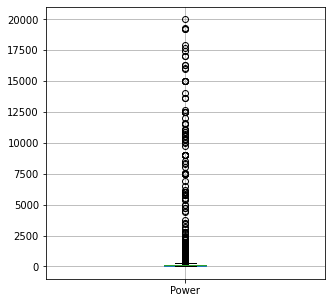

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [7]:
data.boxplot(column='Power', figsize=(5,5), grid=True) 
plt.show()

data['Power'].describe()

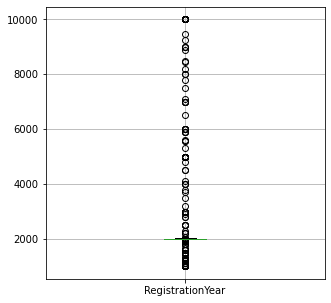

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [8]:
data.boxplot(column='RegistrationYear', figsize=(5,5), grid=True) 
plt.show()

data['RegistrationYear'].describe()

### Предобработка данных

In [9]:
#изменим тип данных в столбцах DateCreated и LastSeen
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format='%Y-%m-%d %H:%M:%S')

#приведём названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()

#приведём к нижнему регистру значения в столбцах типа object
object_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'repaired']
for columns in object_columns:
    data[columns] = data[columns].str.lower()

In [10]:
#Проверка на наличие явных дубликатов
print('Количество явных дубикатов =', data.duplicated().sum())

Количество явных дубикатов = 4


In [11]:
#удалим дубликаты
data = data.drop_duplicates()

Датафрейм содержит пропуски в столбцах с наименованием модели. Данный признак необходим для определения стоимости конкретного автомобиля. Поскольку замена значений в данных строках может значительно исказить информацию о стоимости автомобиля, удалим строки с пропусками

In [12]:
data = data.dropna(subset=['model'])

#### Поиск возможных аномалий в данных

In [13]:
#смотрим уникальные значения в numberofpictures
data['numberofpictures'].unique()

array([0])

In [14]:
#Столбец numberofpictures содержит только нулевые значения. Удаляем его
data = data.drop('numberofpictures', axis=1)

In [15]:
#рассмотрим даты создания анкеты и даты выпуска автомобилей
data['datecrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [16]:
data['registrationyear'].max()

9999

Посмотрим информацию об автомобилях с 1900 года

In [17]:
data[data['registrationyear'] > 1900].sort_values('registrationyear').head(10)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,postalcode,lastseen
82829,2016-03-14 08:51:18,500,NaN,1910,NaN,0,corsa,150000,0,NaN,opel,NaN,2016-03-14,52393,2016-04-03 07:53:55
98056,2016-04-01 12:46:44,1,sedan,1910,manual,10,other,5000,2,gasoline,mercedes_benz,no,2016-04-01,70173,2016-04-01 12:46:44
58883,2016-03-15 21:57:27,1,NaN,1910,NaN,0,3er,150000,0,NaN,bmw,NaN,2016-03-15,74074,2016-04-07 07:17:28
200148,2016-03-25 13:45:45,0,NaN,1910,NaN,0,a4,150000,0,NaN,audi,NaN,2016-03-25,4155,2016-03-31 20:47:37
321995,2016-03-10 15:58:12,180,NaN,1910,manual,0,mondeo,150000,2,petrol,ford,yes,2016-03-10,32832,2016-04-05 13:19:00
183727,2016-04-03 12:48:38,0,bus,1910,NaN,0,transporter,5000,0,NaN,volkswagen,NaN,2016-04-03,84478,2016-04-03 12:48:38
74814,2016-03-21 12:52:05,400,NaN,1910,NaN,60,golf,150000,0,petrol,volkswagen,NaN,2016-03-21,29462,2016-03-25 09:17:54
218273,2016-03-23 00:49:23,1,convertible,1910,manual,0,other,5000,0,petrol,fiat,NaN,2016-03-22,47169,2016-04-05 01:44:25
203230,2016-04-01 15:37:14,400,NaN,1910,manual,170,3er,5000,0,NaN,bmw,NaN,2016-04-01,66333,2016-04-03 11:48:08
276318,2016-03-31 14:58:25,300,NaN,1910,NaN,0,polo,5000,0,NaN,volkswagen,NaN,2016-03-31,53902,2016-04-06 08:16:52


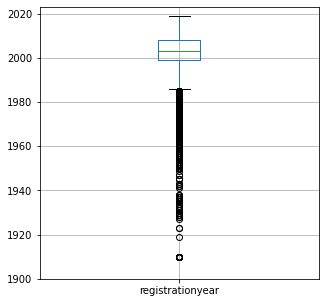

In [18]:
data.boxplot(column='registrationyear', figsize=(5,5), grid=True) 
plt.ylim(1900,2023)
plt.show()

 Первый автомобиль Opel (4/12 Laubfrosch) был выпущен в 1924 году  
 Ford Model T был создан в 1909 году  
 Первый автомобиль BMW создан в 1929 году (BMW Dixi 3/15 PS)  
 первый автомобиль Volkswagen AG создан в 1938 году (Жук)  
 Дата основания компании Jeep - 1941 год  
 Компания citroen была создана в 1919 году 
   
Дата скачивания анкет из базы данных данных происходило в течении марта - апреля 2016 года. Поскольку дата выпуска автомобиля не может быть после даты подачи анкеты о его продаже, то удалим строки с датой выпуска автомобиля после 2016 года. 
  
Раритетным может быть признан легковой автомобиль, с момента производства которого прошло 30 лет или больше (ссылка на статью https://mag.auto.ru/article/kak-priznat-staruyu-mashinu-raritetom-i-zachem-eto-nuzhno/)
  
  Данные о годе выпуска автомобилей имеют явные ошибки, кроме того, малое количество данных о машинах старше 1986 года и специфика подобных автомобилей (раритетеные, коллекционные экземпляры) могут ухудшить качество прогнозов. Исключим из датафрейма данные о таких автомобилях.

In [19]:
data = data.query('1986 <= registrationyear <= 2016')

Определим максимум мощности - не выше 300 л.с. Это ошибочные данные или данные уникальных автомобилей, данных для оценки стоимости которых недостаточно. Установим минимум мощности двигателя в 25 л.с. - https://avtoguru.net/slabachki-rejting-samyh-malomoshhnyh-avtomobilej-za-vsyu-istoriyu-mirovogo-avtoproma-chast-2/

In [20]:
data = data.query('25 < power <= 300')

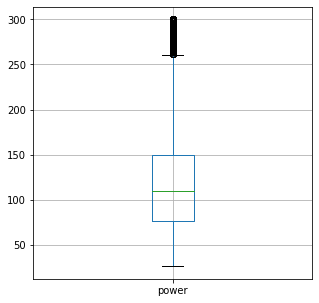

count    284484.000000
mean        118.717035
std          48.497490
min          26.000000
25%          76.000000
50%         110.000000
75%         150.000000
max         300.000000
Name: power, dtype: float64

In [21]:
data.boxplot(column='power', figsize=(5,5), grid=True) 
plt.show()

data['power'].describe()

Дата скачивания анкет из базы данных данных происходило в течении марта - апреля 2016 года.
Дата последней активности пользователя и дата создания анкеты не могут влиять на стоимость автомобиля на коротком промежутке времени 1-2 месяца 2016 года.
Удаляем столбцы 'datecrawled', 'datecreated', 'lastseen' 

In [22]:
data = data.drop(['datecrawled', 'datecreated', 'lastseen'], axis=1)

Установим нижний предел стоимости автомобиля в 200 евро (ссылка на статью "Сколько можно получить денег, если сдать машину как металолом?" https://dzen.ru/a/XYOxGF1jYgCv3auG , стоиимость евро в 2016 году - 75р/евро). Стоимость автомобиля ниже данного значения говорит либо об ошибки в данных, либо об аварийном состоянии автомобиля. 

In [23]:
data = data.query('200 < price')

In [24]:
#пропуски по столбцам в процентах
data.isna().mean()

price                0.000000
vehicletype          0.030814
registrationyear     0.000000
gearbox              0.015523
power                0.000000
model                0.000000
kilometer            0.000000
registrationmonth    0.000000
fueltype             0.042948
brand                0.000000
repaired             0.132911
postalcode           0.000000
dtype: float64

#### Кодирование данных в столбцах 'fueltype', 'repaired' и 'gearbox'

In [25]:
#посмотрим уникальные значения в 'fueltype'
data['fueltype'].unique()

array(['gasoline', 'petrol', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [26]:
#проведем кодировку категориальных признаков. NaN не кодируем
fueltypes = ['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric']
count = 0
for types in fueltypes:  
    data['fueltype'] = data['fueltype'].replace(types, count)
    print(types, '=', count)
    count += 1

petrol = 0
gasoline = 1
lpg = 2
other = 3
hybrid = 4
cng = 5
electric = 6


In [27]:
#посмотрим уникальные значения в 'repaired'
data['vehicletype'].unique()

array(['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', nan,
       'coupe', 'other'], dtype=object)

In [28]:
#проведем кодировку категориальных признаков. NaN не кодируем
vehicletype = ['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'coupe', 'other']
count = 0
for types in vehicletype:  
    data['vehicletype'] = data['vehicletype'].replace(types, count)
    print(types, '=', count)
    count += 1

suv = 0
small = 1
sedan = 2
convertible = 3
bus = 4
wagon = 5
coupe = 6
other = 7


Во избежании искажения результатов прогнозирования, за счет установления большего веса - большим значениям, работать с данными признаками в дальнейшем будем, как с категориальными

In [29]:
#посмотрим количество уникальных значений в 'gearbox'
data['gearbox'].unique()

array(['auto', 'manual', nan], dtype=object)

In [30]:
#проведем замену значений в 'gearbox': 'manual' == 0, 'auto' == 1
data['gearbox'] = data['gearbox'].replace('manual', 0)
data['gearbox'] = data['gearbox'].replace('auto', 1)

#### Заполнение пропусков в столбце 'fueltype'

Строки без пропусков образуют feature_train и target_train, строки с пропусками будут признаками для предсказания типа топлива. Предсказанными значениями заполним пропуски в столбце 'fueltype' используя модели машинного обучения 

In [31]:
#датафрейм из столбцов, которые могут оказать влияние на определение типа топлива
df = data[['registrationyear', 'price', 'gearbox', 'power', 'fueltype', 'model', 'brand']]

In [32]:
#рассмотрим пропуски по столбцам
df.isna().mean()

registrationyear    0.000000
price               0.000000
gearbox             0.015523
power               0.000000
fueltype            0.042948
model               0.000000
brand               0.000000
dtype: float64

In [33]:
#удалим пропуски в 'gearbox'
df = df.dropna(subset=['gearbox'])

In [34]:
#проведем кодировку категориальных признаков  в столбцах 'model', 'brand' 
df = pd.get_dummies(df, columns=['model', 'brand'], drop_first= True)

In [35]:
#признаками будут данные из df для которых известен 'fueltype', таргеты - известные значения 'fueltype'
features_train = df[df['fueltype'].notna()].drop('fueltype', axis=1)
target_train = df[df['fueltype'].notna()]['fueltype']

In [36]:
#признаки для предсказания значения отсутствующих значений 'fueltype'
features_predict = df[df['fueltype'].isna()].drop('fueltype', axis=1)

In [37]:
#распределение классов 'fueltype'
target_train.value_counts()

0.0    170143
1.0     84214
2.0      4086
5.0       457
4.0       178
3.0        53
6.0        33
Name: fueltype, dtype: int64

In [38]:
#список метрик
scoring = ['f1_macro', 'accuracy']

Код в следующей ячейке закомментирован для экономии времени. Результат его выполненения приведен ячейкой ниже. Гиперпараметры  модели были определены с использованием GridSearchCV.

In [39]:
# %%time
# rf = RandomForestClassifier(random_state=12345, n_estimators=100, n_jobs=-1)
# for scor in scoring:
#     param_rf = {'max_depth':range(5,51,15)}
#     grid_rf = GridSearchCV(rf, param_grid=param_rf, cv=5, scoring=scor)
#     grid_rf.fit(features_train, target_train)
    
#     print('Лучшие гиперпараметры', grid_rf.best_params_)
#     print('Максимальное значение', scor, grid_rf.best_score_)

Лучшие гиперпараметры {'max_depth': 50}  
Максимальное значение f1_macro 0.5668745037034534  
Лучшие гиперпараметры {'max_depth': 50}  
Максимальное значение accuracy 0.9225702646370685  
CPU times: user 44min 50s, sys: 14.3 s, total: 45min 5s  
Wall time: 45min 9s  

In [40]:
#проверим результат дамми модели
dm = DummyClassifier()
for scor in scoring:
    scores_dm = cross_val_score(dm, features_train, target_train, cv=5, scoring=scor)
    print(scor, scores_dm.max())

f1_macro 0.11323617740966711
accuracy 0.656524926686217


In [41]:
#создадим модель с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=12345, max_depth=50, n_estimators=100, n_jobs=-1)

In [42]:
%%time
#получим пропущенные признаки в столбце fueltype
rf.fit(features_train, target_train)
predict_fueltype = rf.predict(features_predict)

CPU times: user 1min 56s, sys: 789 ms, total: 1min 57s
Wall time: 1min 57s


In [43]:
#число предсказаний для типа топлива
pd.Series(predict_fueltype).shape[0]

11001

In [44]:
#Заполним пропуски предсказанными значениями
data['fueltype'][features_predict.index] = predict_fueltype

#### Заполнение пропусков в столбце 'gearbox'

In [45]:
#датафрейм из столбцов, которые могут оказать влияние на определение типа коробки передач
df = data[['registrationyear', 'price', 'gearbox', 'power', 'fueltype', 'model', 'brand']]

In [46]:
#рассмотрим пропуски по столбцам
df.isna().mean()

registrationyear    0.000000
price               0.000000
gearbox             0.015523
power               0.000000
fueltype            0.002861
model               0.000000
brand               0.000000
dtype: float64

In [47]:
#удалим пропуски в ''gearbox'
df = df.dropna(subset=['fueltype'])

In [48]:
#проведем кодировку категориальных признаков  встолбцах 'model', 'brand', 'fueltype' 
df = pd.get_dummies(df, columns=['model', 'brand', 'fueltype'], drop_first= True)

In [49]:
#признаками будут данные из df для которых известен 'gearbox', таргеты - известные значения 'gearbox'
features_train = df[df['gearbox'].notna()].drop('gearbox', axis=1)
target_train = df[df['gearbox'].notna()]['gearbox']

In [50]:
#признаки для предсказания значения отсутствующих значений 'gearbox'
features_predict = df[df['gearbox'].isna()].drop('gearbox', axis=1)

In [51]:
#распределение классов 'gearbox'
target_train.value_counts()

0.0    216840
1.0     53325
Name: gearbox, dtype: int64

Код в следующей ячейке закомментирован для экономии времени. Результат его выполненения приведен ячейкой ниже. 

In [52]:
# %%time
# rf = RandomForestClassifier(random_state=12345, n_estimators=100, n_jobs=-1)
# for scor in scoring:
#     param_rf = {'max_depth':range(5,51,15)}
#     grid_rf = GridSearchCV(rf, param_grid=param_rf, cv=5, scoring=scor)
#     grid_rf.fit(features_train, target_train)
    
#     print('Лучшие гиперпараметры', grid_rf.best_params_)
#     print('Максимальное значение', scor, grid_rf.best_score_)

Лучшие гиперпараметры {'max_depth': 50}  
Максимальное значение f1_macro 0.7823280257295788  
Лучшие гиперпараметры {'max_depth': 35}  
Максимальное значение accuracy 0.8752281013454741  
CPU times: user 43min 33s, sys: 13.2 s, total: 43min 47s  
Wall time: 43min 57s  

In [53]:
#проверим результат дамми модели
dm = DummyClassifier()
for scor in scoring:
    scores_dm = cross_val_score(dm, features_train, target_train, cv=5, scoring=scor)
    print(scor, scores_dm.max())

f1_macro 0.44525210213447497
accuracy 0.802620620731775


In [54]:
#создадим модель с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=12345, max_depth=50, n_estimators=100, n_jobs=-1)

In [55]:
%%time
#получим пропущенные признаки в столбце 'gearbox'
rf.fit(features_train, target_train)
predict_gearbox = rf.predict(features_predict)

CPU times: user 2min 2s, sys: 652 ms, total: 2min 3s
Wall time: 2min 3s


In [56]:
#число предсказаний для типа коробки передач
pd.Series(predict_gearbox).shape[0]

3475

In [57]:
#Заполним пропуски предсказанными значениями
data['gearbox'][features_predict.index] = predict_gearbox

#### Заполнение пропусков в столбце 'vehicletype'

In [58]:
#датафрейм из столбцов, которые могут оказать влияние на определение типа топлива
df = data[['vehicletype', 'registrationyear', 'price', 'gearbox', 'power', 'fueltype', 'model', 'brand']]

In [59]:
#рассмотрим пропуски по столбцам
df.isna().mean()

vehicletype         0.030814
registrationyear    0.000000
price               0.000000
gearbox             0.002861
power               0.000000
fueltype            0.002861
model               0.000000
brand               0.000000
dtype: float64

In [60]:
#удалим пропуски в 'gearbox'
df = df.dropna(subset=['gearbox'])

In [61]:
#проведем кодировку категориальных признаков  в столбцах 'model', 'brand' 
df = pd.get_dummies(df, columns=['model', 'brand'], drop_first= True)

In [62]:
#признаками будут данные из df для которых известен 'vehicletype', таргеты - известные значения 'fueltype'
features_train = df[df['vehicletype'].notna()].drop('vehicletype', axis=1)
target_train = df[df['vehicletype'].notna()]['vehicletype']

In [63]:
#признаки для предсказания значения отсутствующих значений 'vehicletype'
features_predict = df[df['vehicletype'].isna()].drop('vehicletype', axis=1)

In [64]:
#распределение классов 'vehicletype'
target_train.value_counts()

2.0    77293
1.0    64847
5.0    56512
4.0    25198
3.0    17338
6.0    12538
0.0     9774
7.0     2025
Name: vehicletype, dtype: int64

Код в следующей ячейке закомментирован для экономии времени. Результат его выполненения приведен ячейкой ниже. 

In [65]:
# %%time
# rf = RandomForestClassifier(random_state=12345, n_estimators=100, n_jobs=-1)
# for scor in scoring:
#     param_rf = {'max_depth':range(5,51,15)}
#     grid_rf = GridSearchCV(rf, param_grid=param_rf, cv=5, scoring=scor)
#     grid_rf.fit(features_train, target_train)
    
#     print('Лучшие гиперпараметры', grid_rf.best_params_)
#     print('Максимальное значение', scor, grid_rf.best_score_)

Лучшие гиперпараметры {'max_depth': 50}  
Максимальное значение f1_macro 0.6900736786851963  
Лучшие гиперпараметры {'max_depth': 50}  
Максимальное значение accuracy 0.759220412390547  
CPU times: user 54min 48s, sys: 20 s, total: 55min 8s  
Wall time: 56min 13s  

In [66]:
#проверим результат дамми модели
dm = DummyClassifier()
for scor in scoring:
    scores_dm = cross_val_score(dm, features_train, target_train, cv=5, scoring=scor)
    print(scor, scores_dm.max())

f1_macro 0.05636704392975906
accuracy 0.2911025327181998


In [67]:
#создадим модель с лучшими гиперпараметрами
rf = RandomForestClassifier(random_state=12345, max_depth=50, n_estimators=100, n_jobs=-1)

In [68]:
%%time
#получим пропущенные признаки в столбце 'vehicletype'
rf.fit(features_train, target_train)
predict_vehicletype = rf.predict(features_predict)

CPU times: user 2min 15s, sys: 1.1 s, total: 2min 16s
Wall time: 2min 17s


In [69]:
#число предсказаний для типа кузова
pd.Series(predict_vehicletype).shape[0]

8115

In [70]:
#Заполним пропуски предсказанными значениями
data['vehicletype'][features_predict.index] = predict_vehicletype

#### Заполнение пропусков в столбце 'repaired'

Понятие серьезного ремонта точно неопределено, кроме того владелец подержанного автомобиля не всегда обладает информацией о проведенном ранее ремонте автомобиля, в таком случае пользователь мог не заполнить сведения о проведенном ремонте. Пропуски в столбце repaired (была машина в ремонте или нет) заменим на unknown

In [71]:
data['repaired'] = data['repaired'].fillna('unknown')

### Подготовка данных для обучения и тестирования моделей 

In [72]:
#удалим пропуски в столбцах 'gearbox' и 'fueltype', которые не удалось заполнить (строки с пропусками в столбцах совпадают)
data = data.dropna(subset=['gearbox'])

In [73]:
#посмотрим количество уникальных значений в столбце 'postalcode'
len(data['postalcode'].unique())

8096

In [74]:
#сбросим индекс после удаления строк
data = data.reset_index(drop=True)

In [75]:
#приведем столбцы к int
data[['vehicletype', 'gearbox', 'fueltype']] = data[['vehicletype', 'gearbox', 'fueltype']].astype(int)

In [76]:
#посмотрим общие сведения о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273640 entries, 0 to 273639
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              273640 non-null  int64 
 1   vehicletype        273640 non-null  int64 
 2   registrationyear   273640 non-null  int64 
 3   gearbox            273640 non-null  int64 
 4   power              273640 non-null  int64 
 5   model              273640 non-null  object
 6   kilometer          273640 non-null  int64 
 7   registrationmonth  273640 non-null  int64 
 8   fueltype           273640 non-null  int64 
 9   brand              273640 non-null  object
 10  repaired           273640 non-null  object
 11  postalcode         273640 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 25.1+ MB


#### Разделение данных на выборки

##### Выборки для работы с моделями, поддерживающими обработку категориальных признаков

In [ ]:
#признаками будут все столбцы за исключением price
features_cat = data.drop('price', axis=1)
#столбец price - целевой признак
target_cat = data['price']

In [78]:
#Разделим данные в пропорции 20:80
features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(features_cat,\
target_cat, test_size=0.2, random_state=12345)

In [79]:
#столбцы с категориальными признаками
col_cat = ['vehicletype', 'model', 'registrationmonth', 'fueltype', 'brand', 'repaired', 'postalcode']

In [80]:
#Проверка корректности проведенного разделения
print('Размер обучающей выборки features_train',features_train_cat.shape[0])
print('Размер обучающей выборки target_train  ',target_train_cat.shape[0])
print('Размер тестовой выборки features_test',features_test_cat.shape[0])
print('Размер тестовой выборки target_test  ',target_test_cat.shape[0])

Размер обучающей выборки features_train 218912
Размер обучающей выборки target_train   218912
Размер тестовой выборки features_test 54728
Размер тестовой выборки target_test   54728


##### Выборки для работы с моделями не поддерживающих обработку категориальных признаков

Исключим столбец 'postalcode', содержащий 8096 уникальных значений

In [81]:
#признаками будут все столбцы за исключением 'price' и 'postalcode'
features = data.drop(['price', 'postalcode'], axis=1)
#столбец price - целевой признак
target = data['price']

In [82]:
#столбцы с категориальными признаками
columns_cat = ['vehicletype', 'model', 'registrationmonth', 'fueltype', 'brand', 'repaired']

In [83]:
#проведем кодировку признаков 
features = pd.get_dummies(features, columns=columns_cat, drop_first= True)

In [84]:
#Разделим данные в пропорции 20:80
features_train, features_test, target_train, target_test = train_test_split(features,\
target, test_size=0.2, random_state=12345)

In [85]:
#Проверка корректности проведенного разделения
print('Размер обучающей выборки features_train',features_train.shape[0])
print('Размер обучающей выборки target_train  ',target_train.shape[0])
print('Размер тестовой выборки features_test',features_test.shape[0])
print('Размер тестовой выборки target_test  ',target_test.shape[0])

Размер обучающей выборки features_train 218912
Размер обучающей выборки target_train   218912
Размер тестовой выборки features_test 54728
Размер тестовой выборки target_test   54728


#### RMSE скорер

Поскольку в дальнейшем предполагается использование оценщика GridSearchCV, то создадим метрику RMSE с помощью make_scorer, установив параметр greater_is_better=False. Использование данной метрики обеспечит поиск наилучших гиперпараметров по меньшему значению RMSE

In [86]:
#создаем функцию для определения RMSE
def def_rmse(target,predicted):
    return mean_squared_error(target, predicted)**0.5

rmse_scor = make_scorer(def_rmse, greater_is_better=False)

### Вывод по разделу 1

Для решения поставлённой задачи в разделе 1 выполнение следующее.
1.	Проведена загрузка данных и ознакомление с ними;
2.	На основе гисторграмм выявлены аномалии в данных;
3.	Удалены строки, содержащие аномалии;
4.	Удалены столбцы 'datecrawled', 'date-created','lastsean', как неинформативные для определения стоимости автомобиля.
5.	Удалены строки, содержащие пропуски в названии модели автомобиля. По мнению автора данной работы модель автомобиля является одним из важнейших признаков, определяющих его стоимость. Возможность достоверно определить модель по иным признакам отсутствует.
6.	Пропуски в солбцах 'fueltype', 'gearbox', 'vehicletype' Заменены с использованием модели RandomForestClassifier. Гиперпараметры модели были подобраны по известным значениям с испольованием GridSearchCV. Полученая модель была проверена на адекватность с использованием DummyClassifier. Получившиеся значения асcuгасу и fl-меры позволяют сказать о значительном превышении точности заполнения пропусков по сравнению с Dummy моделью.
7.	Пропуски в столбце 'repaired' заполнены значениями unknown в связи с отсутствием точного определения серьёзного ремонта. Кроме того, собственник подержанного автомобиля может не обладать информацией о ремонтных работах, проведенных до приобретения автомобиля.
8.	Из данных выделена тестовая выборка. Модели будут проверяться на обучающем наборе с использованием кросс-валидации.
9.	Созданы обучающие и тестовые выборки для моделей поддерживающих обработку категориальных признаков, (пр. CatBoostRegressor, LGBMRegressor) и не поддерживающих (пр.RandomForestRegressor)
10. Создан RMSE скорер для использовании в оценщике GridSearchCV. Использование данной метрики обеспечит поиск наилучших гиперпараметров по меньшему значению RMSE После проведенной предобработки данных количество строк в датасете составило - 273639

## Обучение моделей

### RandomForestRegressor

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [87]:
# %%time
# rf = RandomForestRegressor(random_state=12345, n_estimators=100, n_jobs=-1)
# param = {'max_depth': range (5,51,15)}
# grid_rf = GridSearchCV(rf, param_grid = param, scoring = rmse_scor, cv = 5)
# grid_rf.fit(features_train,target_train)

# print('Лучшие гиперпараметры', grid_rf.best_params_)
# print('Максимальное значение RMSE = ', grid_rf.best_score_)
# print('Время обучения', grid_rf.cv_results_['mean_fit_time'])

Лучшие гиперпараметры {'max_depth': 35}  
Максимальное значение RMSE =  -1473.7875985359285  
Время обучения [113.02057343 306.68897743 372.37146411 385.25264459]  
CPU times: user 1h 46min 20s, sys: 19.5 s, total: 1h 46min 39s  
Wall time: 1h 46min 43s  

In [88]:
#модель с гиперпараметрами, обеспечивающими лучшее значение RMSE
rf = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=35)

Обучим модель с лучшими гиперпараметрами на трейне и найдём время обучения

In [89]:
%%time
rf.fit(features_train, target_train)

CPU times: user 8min 13s, sys: 1.39 s, total: 8min 15s
Wall time: 8min 15s


RandomForestRegressor(max_depth=35, random_state=12345)

Определим время предсказания выбранной модели 

In [90]:
%%time
predictions_rf = rf.predict(features_train)

CPU times: user 10.9 s, sys: 224 ms, total: 11.2 s
Wall time: 11.2 s


### CatBoostRegressor

In [91]:
cbr = CatBoostRegressor(random_state = 1234)

In [92]:
#гиперпараметры для поиска лучшей модели
param = {'l2_leaf_reg': [0.03, 0.1], 'depth': [4, 8]}

Из документации на CatBoostRegressor (https://catboost.ai/en/docs/concepts/python-reference_catboostregressor):  

**depth** - в большинстве случаев оптимальная глубина колеблется от 4 до 10. Рекомендуемые значения от 4 до 8
  
**l2_leaf_reg** - регуляризация L2. Необходимо пробовать разные значения для регуляризатора, чтобы найти наилучее из возможных  

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [93]:
# %%time
# grid_cbr = GridSearchCV(cbr, param_grid = param, scoring = rmse_scor, cv = 5)
# grid_cbr.fit(features_train_cat,target_train_cat, cat_features=col_cat, verbose=False)

# print('Лучшие гиперпараметры', grid_cbr.best_params_)
# print('Максимальное значение RMSE = ', grid_cbr.best_score_)
# print('Время обучения', grid_cbr.cv_results_['mean_fit_time'])

Лучшие гиперпараметры {'depth': 8, 'l2_leaf_reg': 0.03}  
Максимальное значение RMSE =  -1461.477840249185  
Время обучения [170.44856529 172.93329482 410.16363025 408.21683636]  
CPU times: user 1h 44min 7s, sys: 19.9 s, total: 1h 44min 27s  
Wall time: 1h 45min 18s  

In [94]:
#модель с гиперпараметрами, обеспечивающими лучшее значение RMSE
cbr = CatBoostRegressor(random_state = 1234, depth=8, l2_leaf_reg=0.03, cat_features=col_cat, verbose=False)

Обучим модель с лучшими гиперпараметрами на трейне и найдём время обучения

In [95]:
%%time
cbr.fit(features_train_cat, target_train_cat)

CPU times: user 7min 32s, sys: 2.13 s, total: 7min 34s
Wall time: 7min 39s


Определим время предсказания выбранной модели

In [96]:
%%time
predictions_cbr = cbr.predict(features_train_cat)

CPU times: user 6.51 s, sys: 35.9 ms, total: 6.55 s
Wall time: 6.55 s


### LGBMRegressor

In [97]:
#установим тип 'category' для категориальных признаков
features_train_cat[col_cat] = features_train_cat[col_cat].astype('category')
features_test_cat[col_cat] = features_test_cat[col_cat].astype('category')

In [98]:
#гиперпараметры для поиска лучшей модели
param = {'learning_rate': [0.03, 0.1], 'max_depth': [4, 8]}

Из документации на LGMR (https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMRegressor.html)
  
**'learning_rate'** - (float, необязательно (по умолчанию = 0.1)) - повышение скорости обучения    
**'max_depth'** - (int, необязательно (по умолчанию=1)) - максимальная глубина дерева  

In [99]:
lgb = LGBMRegressor(random_state = 1234, n_estimators=100)

Код в следующей ячейке закомментирован для экономии времени. Результат его выполнения приведен в ячейке ниже

In [100]:
# %%time
# grid_lgb = GridSearchCV(lgb, param_grid = param, scoring = rmse_scor, cv = 5)
# grid_lgb.fit(features_train_cat,target_train_cat)

# print('Лучшие гиперпараметры', grid_lgb.best_params_)
# print('Максимальное значение RMSE = ', grid_lgb.best_score_)
# print('Время обучения', grid_lgb.cv_results_['mean_fit_time'])

Лучшие гиперпараметры {'learning_rate': 0.1, 'max_depth': 8}  
Максимальное значение RMSE =  -1500.099726125421  
Время обучения [ 419.83592987 1091.89000707  433.44880333 1009.88167992]  
CPU times: user 4h 10min 56s, sys: 1min 10s, total: 4h 12min 7s  
Wall time: 4h 12min 25s  

In [101]:
#модель с гиперпараметрами, обеспечивающими лучшее значение RMSE
lgb = LGBMRegressor(random_state = 12345, n_estimators=100, learning_rate=0.1, max_depth=8)

Обучим модель с лучшими гиперпараметрами на трейне и найдём время обучения

In [103]:
%%time
lgb.fit(features_train_cat, target_train_cat)

CPU times: user 33.2 s, sys: 91 ms, total: 33.3 s
Wall time: 33.6 s


LGBMRegressor(max_depth=8, random_state=12345)

Определим время предсказания выбранной модели

In [104]:
%%time
predictions_lgb = lgb.predict(features_train_cat)

CPU times: user 2.32 s, sys: 3.4 ms, total: 2.33 s
Wall time: 2.31 s


## Анализ моделей

1. В разделе 2 были рассмотрены 3 модели RandomForestRegressor, CatBoostRegressor, LGBMRegressor   
  
  
2. **Модели, показавшие лучшее значение RMSE:**  
  1) RandomForestRegressor - максимальное значение RMSE = 1473.78     
  2) CatBoostRegressor - максимальное значение RMSE = 1461.47    
  3) LGBMRegressor - максимальное значение RMSE = 1500.09
  
  
3. **Гиперпараметры, обеспечивающие наименьшее значение RMSE** (подобраны с помощью кросс-валидации):  
  1) RandomForestRegressor: {'n_estimators' : 100, 'max_depth' : 35},   
  2) CatBoostRegressor{'depth': 8, 'l2_leaf_reg' : 0.03},  
  3) LGBMRegressor{'n_estimators' : 100, 'learning_rate' : 0.1, 'max_depth' : 8}. 
  
  
4. **Скорость обучения:**

  1) RandomForestRegressor - CPU times: user 8min 13s, sys: 1.39 s, total: 8min 15s, Wall time: 8min 15s   
  2) CatBoostRegressor - CPU times: user 7min 32s, sys: 2.13 s, total: 7min 34s, Wall time: 7min 39s  
  3) LGBMRegressor - CPU times: user 33.2 s, sys: 91 ms, total: 33.3 s, Wall time: 33.6 s  
  
  
5. **Скорость предсказания:**

  1) RandomForestRegressor - CPU times: user 10.9 s, sys: 224 ms, total: 11.2 s, Wall time: 11.2 s   
  2) CatBoostRegressor - CPU times: user 6.51 s, sys: 35.9 ms, total: 6.55 s, Wall time: 6.55 s  
  3) LGBMRegressor - CPU times: user 2.32 s, sys: 3.4 ms, total: 2.33 s, Wall time: 2.31 s   
  
  
6. **Вывод** 

По качеству предсказания лучшая модель CatBoostRegressor, по скорости обучения LGBMRegressor, по скорости предсказания LGBMRegressor. В случае, если важным параметром для решения задачи является скорость обучения модели, то лучшей моделью является LGBMRegressor{'n_estimators' : 100, 'learning_rate' : 0.1, 'max_depth' : 8}.

### Тестирование выбранной модели

In [105]:
%%time
predictions_test_cat = lgb.predict(features_test_cat)

CPU times: user 686 ms, sys: 3.47 ms, total: 689 ms
Wall time: 645 ms


In [106]:
rmse = def_rmse(target_test_cat, predictions_test_cat)
print('RMSE модели LGBMRegressor на тестовой выборке', rmse)

RMSE модели LGBMRegressor на тестовой выборке 1515.5559123284797


##  Общий вывод

Предобработка данных, проведенная в разделе 1 обеспечила высокое качество предсказаний цены автомобиля. Все построенные модели удовлетворяют поставленной задаче и обеспечивают значение RMSE ниже 2500.  Модели показали близкие результаты RMSE на тестовой выборке:

2. **Модели, показавшие лучшее значение RMSE:**  
  1) RandomForestRegressor - максимальное значение RMSE = 1473.78     
  2) CatBoostRegressor - максимальное значение RMSE = 1461.47    
  3) LGBMRegressor - максимальное значение RMSE = 1500.09
  
  
3. **Гиперпараметры, обеспечивающие наименьшее значение RMSE** (подобраны с помощью кросс-валидации):  
  1) RandomForestRegressor: {'n_estimators' : 100, 'max_depth' : 35},   
  2) CatBoostRegressor{'depth': 8, 'l2_leaf_reg' : 0.03},  
  3) LGBMRegressor{'n_estimators' : 100, 'learning_rate' : 0.1, 'max_depth' : 8}. 
  
  
4. **Скорость обучения:**

  1) RandomForestRegressor - CPU times: user 8min 13s, sys: 1.39 s, total: 8min 15s, Wall time: 8min 15s   
  2) CatBoostRegressor - CPU times: user 7min 32s, sys: 2.13 s, total: 7min 34s, Wall time: 7min 39s  
  3) LGBMRegressor - CPU times: user 33.2 s, sys: 91 ms, total: 33.3 s, Wall time: 33.6 s  
  
  
5. **Скорость предсказания:**

  1) RandomForestRegressor - CPU times: user 10.9 s, sys: 224 ms, total: 11.2 s, Wall time: 11.2 s   
  2) CatBoostRegressor - CPU times: user 6.51 s, sys: 35.9 ms, total: 6.55 s, Wall time: 6.55 s  
  3) LGBMRegressor - CPU times: user 2.32 s, sys: 3.4 ms, total: 2.33 s, Wall time: 2.31 s   
  
  
6. **Вывод** 

По качеству предсказания лучшая модель CatBoostRegressor, по скорости обучения LGBMRegressor, по скорости предсказания LGBMRegressor. В случае, если важным параметром для решения задачи является скорость обучения модели, то лучшей моделью является LGBMRegressor{'n_estimators' : 100, 'learning_rate' : 0.1, 'max_depth' : 8}.

Выбранная модель LGBMRegressor{'n_estimators' : 100, 'learning_rate' : 0.1, 'max_depth' : 8} была протестирована на тестовой выборке, показав следующие результаты: RMSE = 1515.55, время предсказание целевого признака: CPU times: user 686 ms, sys: 3.47 ms, total: 689 ms, Wall time: 645 ms